# CNN + MaxPool
Same as CNN_264 which achieved about 60% accuracy on all cell lines except H1.hESC. 

Here, increase K from 4 to 6.

In [1]:
from datetime import datetime
print(datetime.now())

2023-03-26 19:32:15.466612


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy

K=6
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=8 # 20 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000   
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
NUM_CELL_LINES=15
EXCLUSIONS = [1]   # exclude H1.hESC
print('Exclusions:',EXCLUSIONS)

Python 3.9.16
sklearn 1.2.2
Exclusions: [1]


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_VALID = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # else 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_VALID = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # else 'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN)
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

## Model

In [7]:
def build_model():
    ALPHABET=4**K+1  # NUMBER OF DISTINCT KMERS POSSIBLE, add one if N gets mask value
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop1_layer = Dropout(0.5)
    cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool2_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop2_layer = Dropout(0.5)
    flat_layer = Flatten()
    #dens_layer = Dense(DCELLS,activation='relu')
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool1_layer)
    cnn.add(drop1_layer)
    cnn.add(cnn2_layer)
    cnn.add(pool2_layer)
    cnn.add(drop2_layer)
    cnn.add(flat_layer)
    cnn.add(output_layer)

    # Logits=False because sigmoid output is a probability in range [0.,1.]; see
    # https://keras.io/api/losses/probabilistic_losses/#binarycrossentropy-class
    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return cnn

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-03-26 19:32:46.799259
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4995, 4)           16388     
                                                                 
 conv1d (Conv1D)             (None, 4988, 64)          2112      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 1246, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1246, 64)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1239, 64)          32832     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 308, 64)          0         
 1D)                         

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,quick_test=False,score_threshold=0.5):
        self.epochs = epochs
        self.quick_test = quick_test
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map, exclude_middle=False): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            if exclude_middle and oneY >= -2 and oneY <= 0:
                # Exclude middle from train set only, for comparison to Yuan et al
                continue
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        cw = class_weight.compute_class_weight(
            'balanced', classes=[0,1], y=y_train)
        cwd = {0: cw[0], 1: cw[1]}
        print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd) # no validation
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            class_weight=cwd, 
            validation_data=(X_valid,y_valid) ) 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)
        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            if gene_id in self.val_genes:
                self.val_ids.append(allids[t])
                self.val_seq.append(allseq[t])
                self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                self.train_ids.append(allids[t])
                self.train_seq.append(allseq[t])
                self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-03-26 19:32:47.197137
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.
2023-03-26 19:32:56.759450

Training # 1 1
2023-03-26 19:32:56.769451
2023-03-26 19:32:56.769540
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Computed class weights: {0: 1.029723366686286, 1: 0.9719444444444445}
Valid 1:0 458:412 52.64%
FIT
2023-03-26 19:32:57.993182


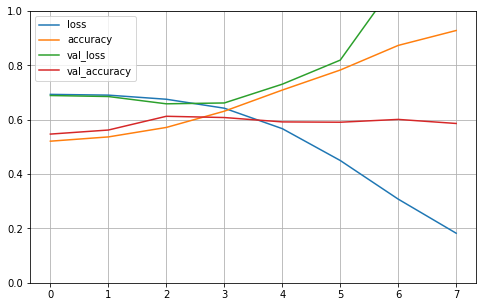


2023-03-26 19:33:45.231871

Testing # 1 1
2023-03-26 19:33:45.233448
2023-03-26 19:33:45.233823
PREDICT
2023-03-26 19:33:45.666409
Test 1:0 458:412 52.64%
Predict 1:0 590:280 67.82%
Test sizes (870, 4995) (870,)
Range of scores: 7.1112813e-09 to 0.99999917
Score threshold 0.5
Confusion matrix
 [[166 246]
 [114 344]]
Normalized matrix
 [[0.1908046  0.28275862]
 [0.13103448 0.3954023 ]]


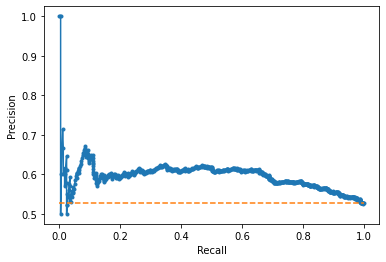

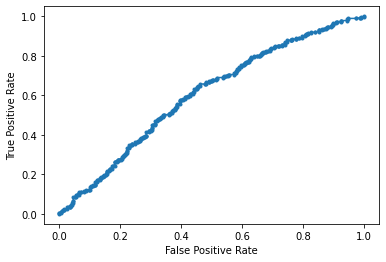

Accuracy: 58.62% Precision: 58.31% Recall: 75.11%
F1: 65.65% MCC: 0.1646
AUPRC: 59.64% AUROC: 60.38%
 accuracy [58.620689655172406]
 precision [58.30508474576271]
 recall [75.10917030567686]
 F1 [65.64885496183206]
 MCC [0.16459219667955402]
 AUPRC [59.63885739023039]
 AUROC [60.37992326281425]
2023-03-26 19:33:46.841084

Training # 1 2
2023-03-26 19:33:46.842765
2023-03-26 19:33:46.843109
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Computed class weights: {0: 1.0440383463151588, 1: 0.9595264317180616}
Valid 1:0 442:442 50.00%
FIT
2023-03-26 19:33:48.281277


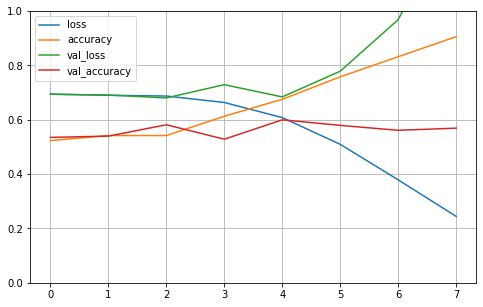


2023-03-26 19:34:18.946259

Testing # 1 2
2023-03-26 19:34:18.946652
2023-03-26 19:34:18.946686
PREDICT
2023-03-26 19:34:19.186685
Test 1:0 442:442 50.00%
Predict 1:0 527:357 59.62%
Test sizes (884, 4995) (884,)
Range of scores: 1.8569523e-07 to 0.9999999
Score threshold 0.5
Confusion matrix
 [[209 233]
 [148 294]]
Normalized matrix
 [[0.23642534 0.26357466]
 [0.16742081 0.33257919]]


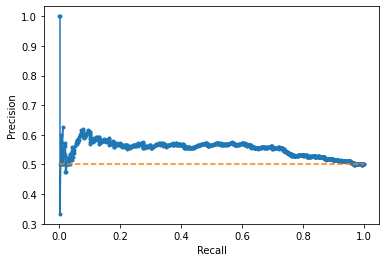

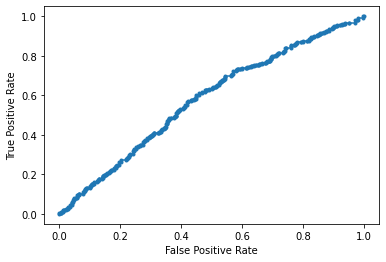

Accuracy: 56.90% Precision: 55.79% Recall: 66.52%
F1: 60.68% MCC: 0.1406
AUPRC: 55.45% AUROC: 57.90%
 accuracy [56.90045248868778]
 precision [55.787476280834916]
 recall [66.51583710407239]
 F1 [60.68111455108358]
 MCC [0.14063402912307899]
 AUPRC [55.454838394579276]
 AUROC [57.89807743494195]
2023-03-26 19:34:20.252589

Training # 1 3
2023-03-26 19:34:20.254250
2023-03-26 19:34:20.254315
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Computed class weights: {0: 1.0328638497652582, 1: 0.9691629955947136}
Valid 1:0 442:407 52.06%
FIT
2023-03-26 19:34:21.495136


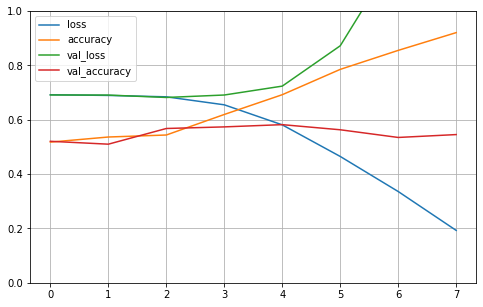


2023-03-26 19:34:49.860339

Testing # 1 3
2023-03-26 19:34:49.860700
2023-03-26 19:34:49.860748
PREDICT
2023-03-26 19:34:50.102349
Test 1:0 442:407 52.06%
Predict 1:0 412:437 48.53%
Test sizes (849, 4995) (849,)
Range of scores: 5.9822623e-06 to 0.9999989
Score threshold 0.5
Confusion matrix
 [[229 178]
 [208 234]]
Normalized matrix
 [[0.26972909 0.20965842]
 [0.24499411 0.27561837]]


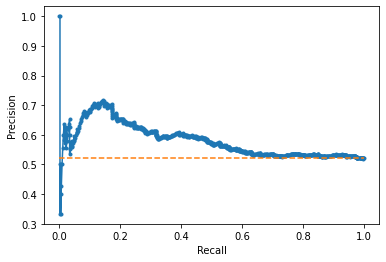

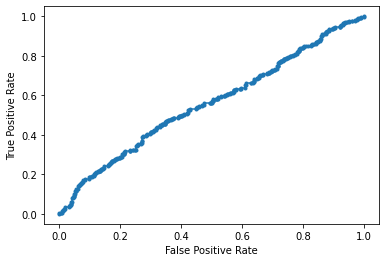

Accuracy: 54.53% Precision: 56.80% Recall: 52.94%
F1: 54.80% MCC: 0.0920
AUPRC: 58.08% AUROC: 56.00%
 accuracy [54.53474676089517]
 precision [56.79611650485437]
 recall [52.94117647058824]
 F1 [54.80093676814989]
 MCC [0.09202696818990562]
 AUPRC [58.08418024724905]
 AUROC [55.9985324691207]
2023-03-26 19:34:51.015680

Training # 1 4
2023-03-26 19:34:51.016815
2023-03-26 19:34:51.016865
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Computed class weights: {0: 1.0354166666666667, 1: 0.9669260700389105}
Valid 1:0 459:431 51.57%
FIT
2023-03-26 19:34:52.741745


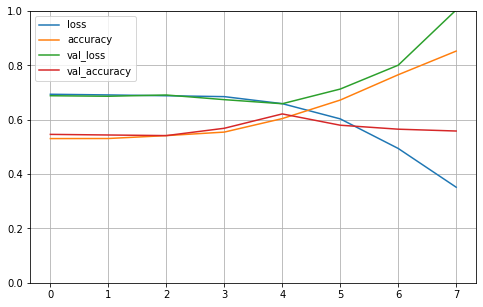


2023-03-26 19:35:35.481451

Testing # 1 4
2023-03-26 19:35:35.481556
2023-03-26 19:35:35.481592
PREDICT
2023-03-26 19:35:35.724556
Test 1:0 459:431 51.57%
Predict 1:0 452:438 50.79%
Test sizes (890, 4995) (890,)
Range of scores: 0.0012035668 to 0.9999938
Score threshold 0.5
Confusion matrix
 [[238 193]
 [200 259]]
Normalized matrix
 [[0.26741573 0.21685393]
 [0.2247191  0.29101124]]


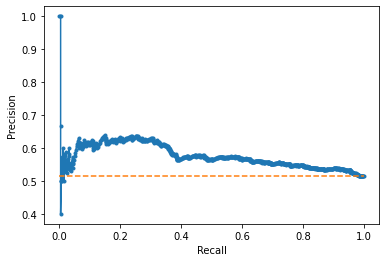

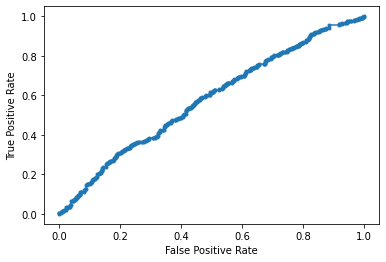

Accuracy: 55.84% Precision: 57.30% Recall: 56.43%
F1: 56.86% MCC: 0.1164
AUPRC: 57.65% AUROC: 57.81%
 accuracy [55.842696629213485]
 precision [57.30088495575221]
 recall [56.42701525054466]
 F1 [56.86059275521404]
 MCC [0.11643107888551513]
 AUPRC [57.6484279277856]
 AUROC [57.81002785233712]
2023-03-26 19:35:36.604673

Training # 1 5
2023-03-26 19:35:36.605488
2023-03-26 19:35:36.605537
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Computed class weights: {0: 1.032210401891253, 1: 0.9697390338700722}
Valid 1:0 457:419 52.17%
FIT
2023-03-26 19:35:37.833544


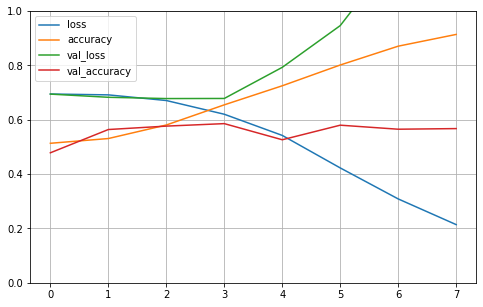


2023-03-26 19:36:08.032971

Testing # 1 5
2023-03-26 19:36:08.033087
2023-03-26 19:36:08.033125
PREDICT
2023-03-26 19:36:08.276061
Test 1:0 457:419 52.17%
Predict 1:0 550:326 62.79%
Test sizes (876, 4995) (876,)
Range of scores: 5.277268e-06 to 0.9999999
Score threshold 0.5
Confusion matrix
 [[183 236]
 [143 314]]
Normalized matrix
 [[0.20890411 0.26940639]
 [0.16324201 0.35844749]]


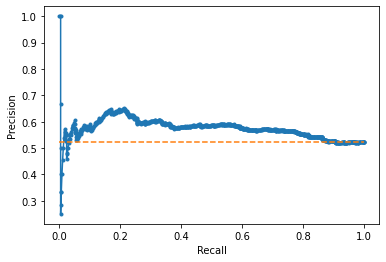

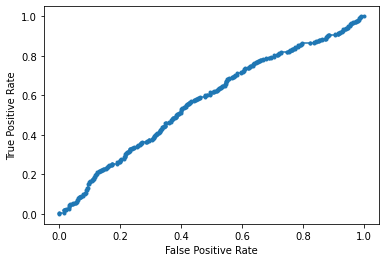

Accuracy: 56.74% Precision: 57.09% Recall: 68.71%
F1: 62.36% MCC: 0.1280
AUPRC: 57.48% AUROC: 57.31%
 accuracy [56.7351598173516]
 precision [57.09090909090909]
 recall [68.7089715536105]
 F1 [62.36345580933465]
 MCC [0.12798219642236494]
 AUPRC [57.47864050063285]
 AUROC [57.307437213747434]
2023-03-26 19:36:09.351360

Training # 2 1
2023-03-26 19:36:09.351571
2023-03-26 19:36:09.351621
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Computed class weights: {0: 1.0265330188679245, 1: 0.9748040313549832}
Valid 1:0 472:415 53.21%
FIT
2023-03-26 19:36:10.610909


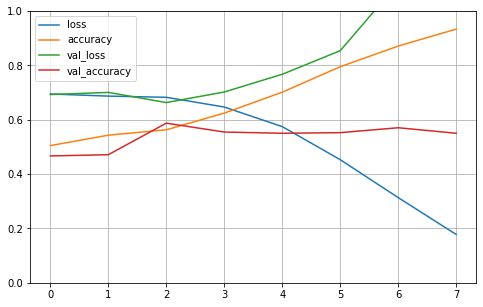


2023-03-26 19:36:39.674237

Testing # 2 1
2023-03-26 19:36:39.675730
2023-03-26 19:36:39.676108
PREDICT
2023-03-26 19:36:40.153580
Test 1:0 472:415 53.21%
Predict 1:0 473:414 53.33%
Test sizes (887, 4995) (887,)
Range of scores: 2.2023283e-10 to 0.9999981
Score threshold 0.5
Confusion matrix
 [[215 200]
 [199 273]]
Normalized matrix
 [[0.24239008 0.22547914]
 [0.22435175 0.30777903]]


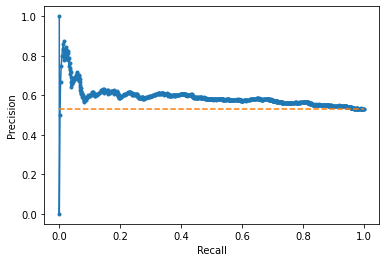

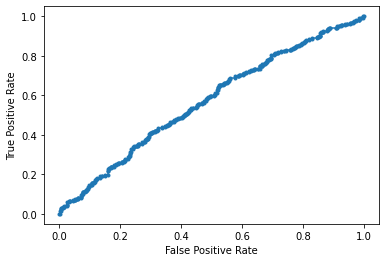

Accuracy: 55.02% Precision: 57.72% Recall: 57.84%
F1: 57.78% MCC: 0.0965
AUPRC: 59.05% AUROC: 57.03%
 accuracy [55.01691093573844]
 precision [57.71670190274841]
 recall [57.83898305084746]
 F1 [57.777777777777786]
 MCC [0.09647640403745057]
 AUPRC [59.046269879010225]
 AUROC [57.0333877884419]
2023-03-26 19:36:41.300262

Training # 2 2
2023-03-26 19:36:41.300472
2023-03-26 19:36:41.300522
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Computed class weights: {0: 1.0327433628318583, 1: 0.9692691029900332}
Valid 1:0 452:416 52.07%
FIT
2023-03-26 19:36:42.847305


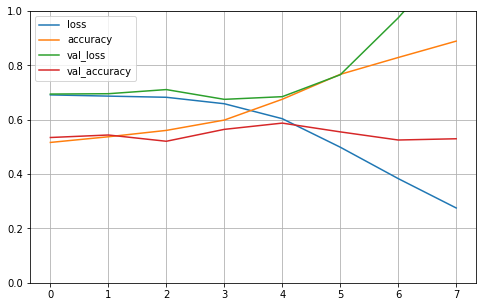


2023-03-26 19:37:25.170576

Testing # 2 2
2023-03-26 19:37:25.170670
2023-03-26 19:37:25.170703
PREDICT
2023-03-26 19:37:25.406670
Test 1:0 452:416 52.07%
Predict 1:0 450:418 51.84%
Test sizes (868, 4995) (868,)
Range of scores: 4.6647147e-06 to 0.9999125
Score threshold 0.5
Confusion matrix
 [[213 203]
 [205 247]]
Normalized matrix
 [[0.24539171 0.23387097]
 [0.23617512 0.28456221]]


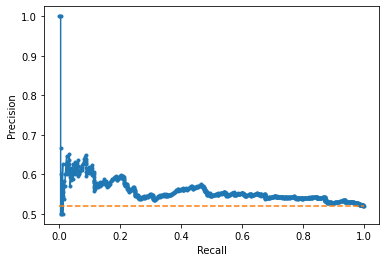

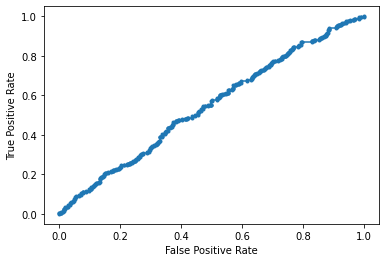

Accuracy: 53.00% Precision: 54.89% Recall: 54.65%
F1: 54.77% MCC: 0.0585
AUPRC: 55.84% AUROC: 54.64%
 accuracy [52.995391705069125]
 precision [54.888888888888886]
 recall [54.64601769911505]
 F1 [54.767184035476724]
 MCC [0.05846883636434808]
 AUPRC [55.83939690105177]
 AUROC [54.64176310415249]
2023-03-26 19:37:26.273748

Training # 2 3
2023-03-26 19:37:26.274677
2023-03-26 19:37:26.274733
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Computed class weights: {0: 1.0296361502347418, 1: 0.97202216066482}
Valid 1:0 453:407 52.67%
FIT
2023-03-26 19:37:27.528740


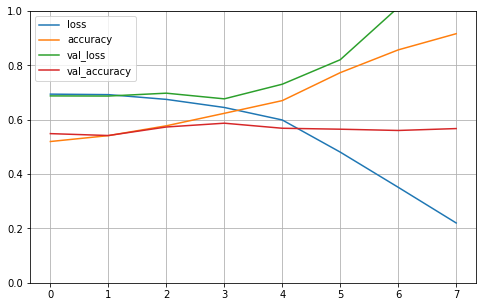


2023-03-26 19:37:56.986931

Testing # 2 3
2023-03-26 19:37:56.987024
2023-03-26 19:37:56.987069
PREDICT
2023-03-26 19:37:57.211957
Test 1:0 453:407 52.67%
Predict 1:0 507:353 58.95%
Test sizes (860, 4995) (860,)
Range of scores: 1.2332434e-06 to 0.99999774
Score threshold 0.5
Confusion matrix
 [[194 213]
 [159 294]]
Normalized matrix
 [[0.2255814  0.24767442]
 [0.18488372 0.34186047]]


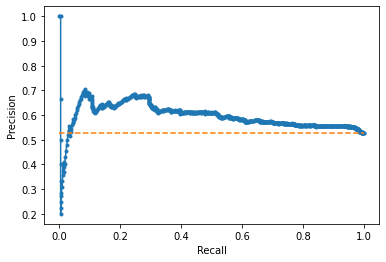

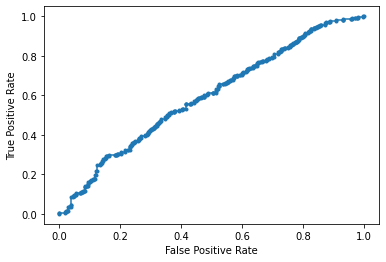

Accuracy: 56.74% Precision: 57.99% Recall: 64.90%
F1: 61.25% MCC: 0.1275
AUPRC: 59.66% AUROC: 59.53%
 accuracy [56.74418604651162]
 precision [57.98816568047337]
 recall [64.90066225165563]
 F1 [61.24999999999999]
 MCC [0.12754682479791343]
 AUPRC [59.6586267322276]
 AUROC [59.52671515585423]
2023-03-26 19:37:58.698559

Training # 2 4
2023-03-26 19:37:58.700361
2023-03-26 19:37:58.700751
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Computed class weights: {0: 1.0486778846153846, 1: 0.9556407447973713}
Valid 1:0 432:447 49.15%
FIT
2023-03-26 19:38:00.962041


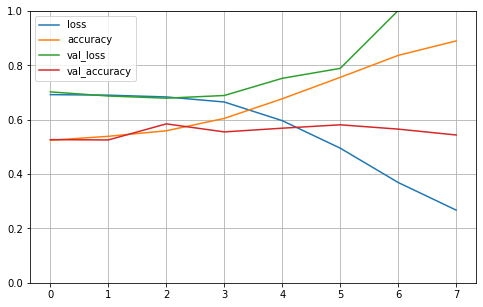


2023-03-26 19:38:43.458663

Testing # 2 4
2023-03-26 19:38:43.459072
2023-03-26 19:38:43.459106
PREDICT
2023-03-26 19:38:43.694705
Test 1:0 432:447 49.15%
Predict 1:0 307:572 34.93%
Test sizes (879, 4995) (879,)
Range of scores: 4.2875176e-06 to 0.9999343
Score threshold 0.5
Confusion matrix
 [[309 138]
 [263 169]]
Normalized matrix
 [[0.35153584 0.15699659]
 [0.29920364 0.19226394]]


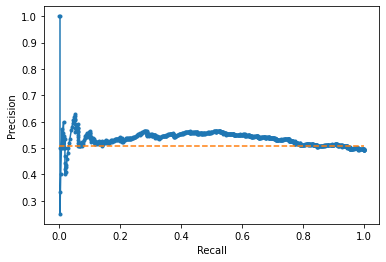

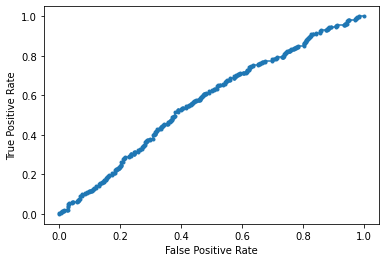

Accuracy: 54.38% Precision: 55.05% Recall: 39.12%
F1: 45.74% MCC: 0.0865
AUPRC: 53.58% AUROC: 57.06%
 accuracy [54.37997724687145]
 precision [55.048859934853425]
 recall [39.120370370370374]
 F1 [45.73748308525034]
 MCC [0.08649104471929293]
 AUPRC [53.57994082131775]
 AUROC [57.05526555638413]
2023-03-26 19:38:44.597328

Training # 2 5
2023-03-26 19:38:44.597514
2023-03-26 19:38:44.597566
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Computed class weights: {0: 1.0367952522255193, 1: 0.9657269209508016}
Valid 1:0 449:426 51.31%
FIT
2023-03-26 19:38:45.836465


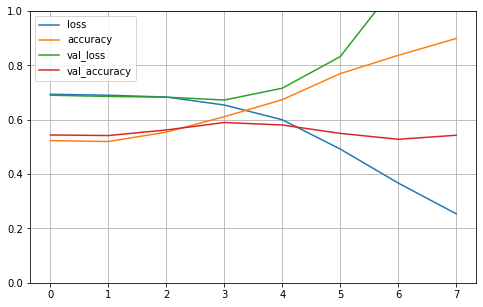


2023-03-26 19:39:28.118543

Testing # 2 5
2023-03-26 19:39:28.118639
2023-03-26 19:39:28.118682
PREDICT
2023-03-26 19:39:28.343287
Test 1:0 449:426 51.31%
Predict 1:0 497:378 56.80%
Test sizes (875, 4995) (875,)
Range of scores: 2.7067392e-06 to 0.9999896
Score threshold 0.5
Confusion matrix
 [[202 224]
 [176 273]]
Normalized matrix
 [[0.23085714 0.256     ]
 [0.20114286 0.312     ]]


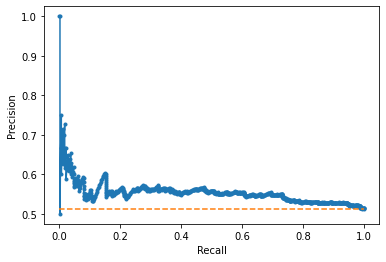

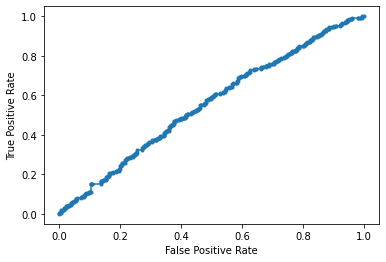

Accuracy: 54.29% Precision: 54.93% Recall: 60.80%
F1: 57.72% MCC: 0.0829
AUPRC: 55.41% AUROC: 55.47%
 accuracy [54.285714285714285]
 precision [54.929577464788736]
 recall [60.801781737193764]
 F1 [57.71670190274841]
 MCC [0.08293841425657571]
 AUPRC [55.40827386038757]
 AUROC [55.47277727239458]
2023-03-26 19:39:29.152181


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_sequence(filepath)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_sequence(filepath)
    print('Loaded',len(test_allseq),'sequences.')

REPEATS = 2
FOLDS = 5
for repeat in range(REPEATS):
    for fold in range(FOLDS):
        r = repeat+1
        f = fold+1

        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,r,f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            test_allids = None
            test_allseq = None
            test_gene_to_rci = None
            
        print(datetime.now())
        print()
        print("Training #",r,f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS,BREAK)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        cvdo.train_new_model(
            train_allids,train_allseq,train_gene_to_rci,
            test_allids,test_allseq,test_gene_to_rci)
           
        print()
        print(datetime.now())
        print()
        print("Testing #",r,f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.2f%% std %.2f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 55.61% std 1.66
 precision mean 56.59% std 1.32
 recall mean 59.70% std 10.01
 F1 mean 57.76% std 5.45
 MCC mean 0.11% std 0.03
 AUPRC mean 57.18% std 2.05
 AUROC mean 57.31% std 1.74
 accuracy [[58.620689655172406], [56.90045248868778], [54.53474676089517], [55.842696629213485], [56.7351598173516], [55.01691093573844], [52.995391705069125], [56.74418604651162], [54.37997724687145], [54.285714285714285]]
 precision [[58.30508474576271], [55.787476280834916], [56.79611650485437], [57.30088495575221], [57.09090909090909], [57.71670190274841], [54.888888888888886], [57.98816568047337], [55.048859934853425], [54.929577464788736]]
 recall [[75.10917030567686], [66.51583710407239], [52.94117647058824], [56.42701525054466], [68.7089715536105], [57.83898305084746], [54.64601769911505], [64.90066225165563], [39.120370370370374], [60.801781737193764]]
 F1 [[65.64885496183206], [60.68111455108358], [54.80093676814989], [56.86059275521404], [62.36345580933465], [57.777777777777786],